In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

In [2]:
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

## Набор данных

Набор данных содержит информацию о состоянии преступности в России за каждый месяц, начиная с 2003 года по 2020.

In [3]:
df = pd.read_csv(r"D:\YandexDisk\datasets\daily-bitcoin-stock-2018-2021.csv").rename( columns={'Unnamed: 0':'date_day'}).rename(str.lower, axis='columns')
date_days = pd.to_datetime(df.pop('date_day'), format='%Y.%m.%d')

my_col_name = 'close_usd'
my_time_name = 'days'
my_plot_cols = ['open_usd', 'high_usd', 'close_usd']

my_width = 24
my_shift = 1

my_conv_width = 3
wide_label_width = 24
wide_input_width = wide_label_width + (my_conv_width - 1)

my_out_steps = 24
OUT_STEPS = 24
CONV_WIDTH = 3

df.head()

,open_sar,open_usd,high_sar,high_usd,low_sar,low_usd,close_sar,close_usd,volume
0,128437.248512,34246.28,131012.723200,34933.00,123106.880000,32825.00,128333.212416,34218.54,43072
1,125144.022272,33368.18,144510.037760,38531.90,119695.516160,31915.40,128459.450880,34252.20,231827
2,113870.357376,30362.19,126703.438592,33783.98,111919.811840,29842.10,125131.570944,33364.86,92621
3,121753.023104,32464.01,122102.860416,32557.29,109668.146688,29241.72,113885.208960,30366.15,95911
4,120966.114176,32254.19,123470.218752,32921.88,115652.472448,30837.37,121767.124608,32467.77,84972


In [4]:
date_days.head(15)

0    2021-01-30
1    2021-01-29
2    2021-01-28
3    2021-01-27
4    2021-01-26
5    2021-01-25
6    2021-01-24
7    2021-01-23
8    2021-01-22
9    2021-01-21
10   2021-01-20
11   2021-01-19
12   2021-01-18
13   2021-01-17
14   2021-01-16
Name: date_day, dtype: datetime64[ns]

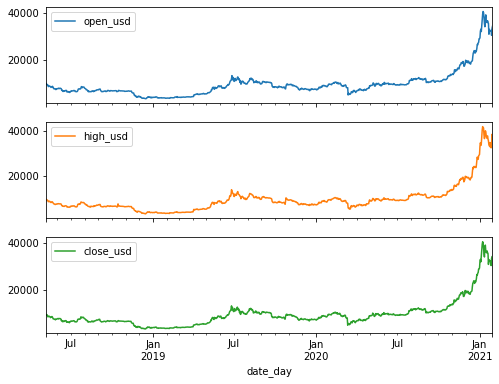

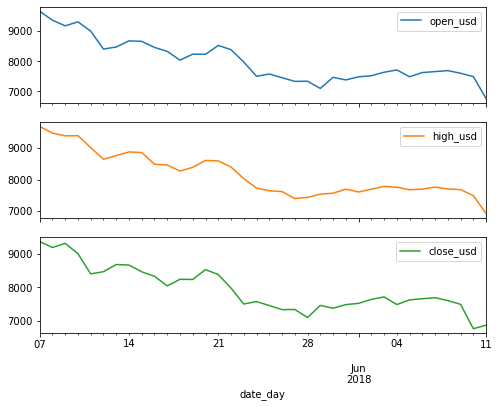

In [5]:
plot_features = df[my_plot_cols]
plot_features.index = date_days
hello = plot_features.plot(subplots=True)

plot_features = df[my_plot_cols][-36:]
plot_features.index = date_days[-36:]
_ = plot_features.plot(subplots=True)

In [6]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
open_sar,1000.0,34825.322255,21728.028028,12045.197184,24254.558752,30714.632128,38317.311744,152217.334784
open_usd,1000.0,9285.762120,5793.522832,3211.710000,6467.192500,8189.695000,10216.860000,40586.960000
high_sar,1000.0,35789.618165,22785.946842,12288.185600,24686.089152,31321.953152,39077.527200,157329.280000
high_usd,1000.0,9542.880270,6075.604427,3276.500000,6582.255000,8351.630000,10419.562500,41950.000000
low_sar,1000.0,33796.329057,20565.410145,11837.237504,23721.336256,30010.869568,37158.878816,145215.488000
low_usd,1000.0,9011.393200,5483.524463,3156.260000,6325.015000,8002.045000,9907.977500,38720.000000
close_sar,1000.0,34917.483572,21928.280072,12045.234688,24252.946080,30713.263232,38329.725568,152201.770624
close_usd,1000.0,9310.335850,5846.917681,3211.720000,6466.762500,8189.330000,10220.170000,40582.810000
volume,1000.0,53100.498000,35329.832031,5743.000000,30045.750000,43795.500000,64909.250000,402201.000000


## Разбиение данных

Обучение – 70%,
валидация – 20%,
проверка – 10%.

In [7]:
column_indices = {name: i for i, name in enumerate(df.columns)}
column_indices

{'open_sar': 0,
 'open_usd': 1,
 'high_sar': 2,
 'high_usd': 3,
 'low_sar': 4,
 'low_usd': 5,
 'close_sar': 6,
 'close_usd': 7,
 'volume': 8}

In [8]:
n = len(df)

train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

val_performance = {}
test_performance = {}

val_performance2 = {}
test_performance2 = {}

multi_val_performance = {}
multi_test_performance = {}

num_features = df.shape[1]

## Нормализация данных

In [9]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

## Окно данных (data windowing)

Модели делают набор прогнозов на основе окна последовательных выборок из данных.

Пример:
![](images/data-windowing.png)

In [10]:
class WindowGenerator:
    def __init__(self, input_width, label_width, shift,
                 train_df, val_df, test_df,
                 label_columns=None):

        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                          enumerate(label_columns)}

        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]

        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1)

        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels

    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32,)

        ds = ds.map(self.split_window)
        return ds

    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def example(self):
        result = getattr(self, '_example', None)
        if result is None:
            result = next(iter(self.train))
            self._example = result

        return result

    def __repr__(self):
        return '\n'.join([
            f'total window size: {self.total_window_size}',
            f'input indices: {self.input_indices}',
            f'label indices: {self.label_indices}',
            f'label column name(s): {self.label_columns}'])

    def plot(self, model=None, plot_col='unnamed', plot_time='unnamed', max_subplots=3):
        inputs, labels = self.example
        plot_col_index = self.column_indices[plot_col]

        plt.figure(figsize=(12, 8))
        max_n = min(max_subplots, len(inputs))

        for n in range(max_n):
            plt.subplot(max_n, 1, n+1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='inputs', marker='.', zorder=-10)

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', label='labels', c='#2ca02c', s=64)

            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                            marker='X', edgecolors='k', label='predictions',
                            c='#ff7f0e', s=64)

            if n == 0:
                plt.legend()

        plt.xlabel(plot_time)

## Проверка класса WindowGenerator

In [11]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     train_df=train_df, val_df=val_df, test_df=test_df,
                     label_columns=[my_col_name])
w1

total window size: 48
input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
label indices: [47]
label column name(s): ['close_usd']

In [12]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     train_df=train_df, val_df=val_df, test_df=test_df,
                     label_columns=[my_col_name])
w2

total window size: 7
input indices: [0 1 2 3 4 5]
label indices: [6]
label column name(s): ['close_usd']

In [13]:
example_features = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[50:50+w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_features)

print('all shapes are: (batch, time, features)')
print(f'window shape: {example_features.shape}')
print(f'inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

all shapes are: (batch, time, features)
window shape: (3, 7, 9)
inputs shape: (3, 6, 9)
labels shape: (3, 1, 1)


In [73]:
w2.train.element_spec

(TensorSpec(shape=(None, 6, 9), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [15]:
for example_inputs, example_labels in w2.train.take(1):
    print(f'inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'labels shape (batch, time, features): {example_labels.shape}')

inputs shape (batch, time, features): (32, 6, 9)
labels shape (batch, time, features): (32, 1, 1)


## Одношаговые модели

Модель, которая предсказывает значение одного признака на 1 шаг (в нашем случае 1 месяц) в будущем, основываясь только на текущих условиях.

![](images/model-single-step.png)

In [16]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=[my_col_name],
    train_df=train_df, val_df=val_df, test_df=test_df)
single_step_window

total window size: 2
input indices: [0]
label indices: [1]
label column name(s): ['close_usd']

In [17]:
for example_inputs, example_labels in single_step_window.train.take(1):
    print(f'inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'labels shape (batch, time, features): {example_labels.shape}')

inputs shape (batch, time, features): (32, 1, 9)
labels shape (batch, time, features): (32, 1, 1)


## Линия отсчёта (baseline)

Необходимо предсказать кол-во преступлений в следующем месяце, учитывая текущее значение всех признаков.

Определим модель – линия отсчёта – которая просто возвращает текущее кол-во преступлений в качестве прогноза, тем самым предсказывая никаких изменений. Такая модель имеет смысл, поскольку уровень преступности изменятся в следующем месяце, по сравнением с текущим, небольшим скачком.

![](images/model-baseline.png)

In [18]:
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs

        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]

In [74]:
baseline = Baseline(label_index=column_indices[my_col_name])
baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance['baseline'] = baseline.evaluate(single_step_window.val)
test_performance['baseline'] = baseline.evaluate(single_step_window.test)

4/4 [==============================] - 0s 2ms/step - loss: 0.0153 - mean_absolute_error: 0.0623


In [20]:
wide_window = WindowGenerator(
    input_width=my_width, label_width=my_width, shift=my_shift,
    label_columns=[my_col_name],
    train_df=train_df, val_df=val_df, test_df=test_df)
wide_window

total window size: 25
input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
label column name(s): ['close_usd']

In [21]:
print('input shape:', wide_window.example[0].shape)
print('output shape:', baseline(wide_window.example[0]).shape)

input shape: (32, 24, 9)
output shape: (32, 24, 1)


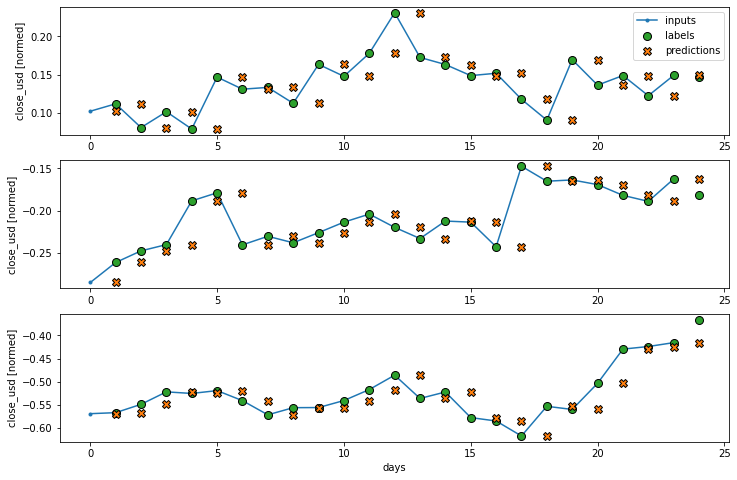

In [22]:
wide_window.plot(baseline, plot_col=my_col_name, plot_time=my_time_name)

## Линейная модель

Линейное преобразование между входом и выходом. Модель ```layers.Dense``` без активации – линейная модель.

Одним из преимуществ линейных моделей является то, что они относительно просты в интерпретации. Вы можете вытащить веса слоя и увидеть вес, назначенный каждому входу:

![](images/model-linear.png)

In [23]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

print('input shape:', single_step_window.example[0].shape)
print('output shape:', linear(single_step_window.example[0]).shape)

input shape: (32, 1, 9)
output shape: (32, 1, 1)


In [24]:
def compile_and_fit(model, window, patience=2, epochs=20):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=patience,
                                                      mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                  optimizer=tf.optimizers.Adam(),
                  metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=epochs,
                        validation_data=window.val,
                        callbacks=[early_stopping])

    return history

In [25]:
%%time
history = compile_and_fit(linear, single_step_window)

val_performance['linear'] = linear.evaluate(single_step_window.val)
test_performance['linear'] = linear.evaluate(single_step_window.test)

Epoch 1/20
22/22 [==============================] - 0s 18ms/step - loss: 1.0672 - mean_absolute_error: 0.6119 - val_loss: 0.5442 - val_mean_absolute_error: 0.6597
Epoch 2/20
22/22 [==============================] - 0s 11ms/step - loss: 0.7946 - mean_absolute_error: 0.5287 - val_loss: 0.3714 - val_mean_absolute_error: 0.5282
Epoch 3/20
22/22 [==============================] - 0s 11ms/step - loss: 0.5851 - mean_absolute_error: 0.4538 - val_loss: 0.2427 - val_mean_absolute_error: 0.4078
Epoch 4/20
22/22 [==============================] - 0s 10ms/step - loss: 0.4213 - mean_absolute_error: 0.3865 - val_loss: 0.159

In [26]:
print('input shape:', wide_window.example[0].shape)
print('output shape:', baseline(wide_window.example[0]).shape)

input shape: (32, 24, 9)
output shape: (32, 24, 1)


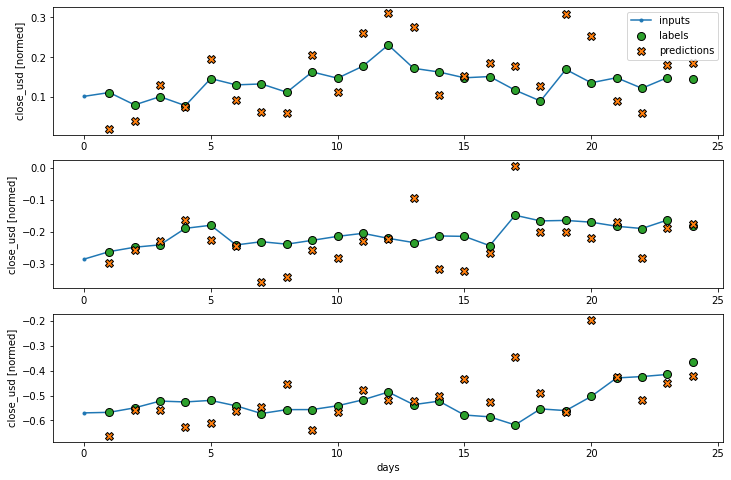

In [27]:
wide_window.plot(linear, plot_col=my_col_name, plot_time=my_time_name)

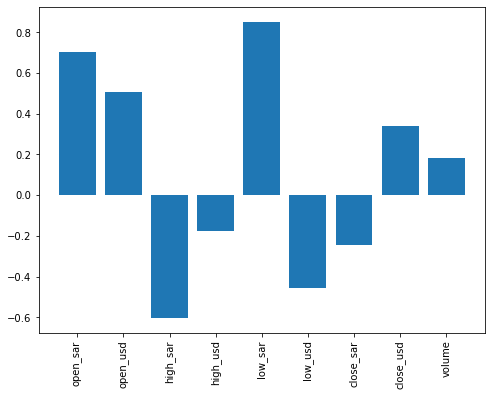

In [28]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

## Полносвязанная модель (dense)

In [29]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

In [30]:
%%time
history = compile_and_fit(dense, single_step_window)

val_performance['dense'] = dense.evaluate(single_step_window.val)
test_performance['dense'] = dense.evaluate(single_step_window.test)

Epoch 1/20
22/22 [==============================] - 0s 17ms/step - loss: 0.4112 - mean_absolute_error: 0.2083 - val_loss: 0.0040 - val_mean_absolute_error: 0.0494
Epoch 2/20
22/22 [==============================] - 0s 10ms/step - loss: 0.0185 - mean_absolute_error: 0.0713 - val_loss: 0.0025 - val_mean_absolute_error: 0.0434
Epoch 3/20
22/22 [==============================] - 0s 11ms/step - loss: 0.0057 - mean_absolute_error: 0.0419 - val_loss: 5.0837e-04 - val_mean_absolute_error: 0.0177
Epoch 4/20
22/22 [==============================] - 0s 11ms/step - loss: 0.0035 - mean_absolute_error: 0.0340 - val_loss: 7.401

## Многошаговая полносвязанная модель

Модель будет принимать несколько временных шагов в качестве входных данных для получения одного вывода.

![](images/model-multi-step-dense.png)

In [31]:
conv_window = WindowGenerator(
    input_width=my_conv_width, label_width=1, shift=my_shift,
    label_columns=[my_col_name],
    train_df=train_df, val_df=val_df, test_df=test_df)
conv_window

total window size: 4
input indices: [0 1 2]
label indices: [3]
label column name(s): ['close_usd']

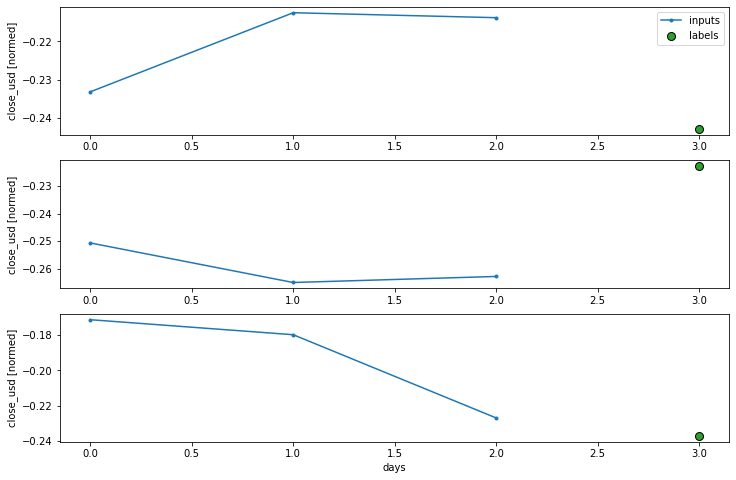

In [32]:
conv_window.plot(plot_col=my_col_name, plot_time=my_time_name)

In [33]:
multi_step_dense = tf.keras.Sequential([
    # shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # add back the time dimension
    # shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [34]:
print('input shape:', conv_window.example[0].shape)
print('output shape:', multi_step_dense(conv_window.example[0]).shape)

input shape: (32, 3, 9)
output shape: (32, 1, 1)


In [35]:
%%time
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['multi_step'] = multi_step_dense.evaluate(conv_window.val)
test_performance['multi_step'] = multi_step_dense.evaluate(conv_window.test)

4/4 [==============================] - 0s 2ms/step - loss: 9.8139e-04 - mean_absolute_error: 0.0238
Wall time: 2.68 s


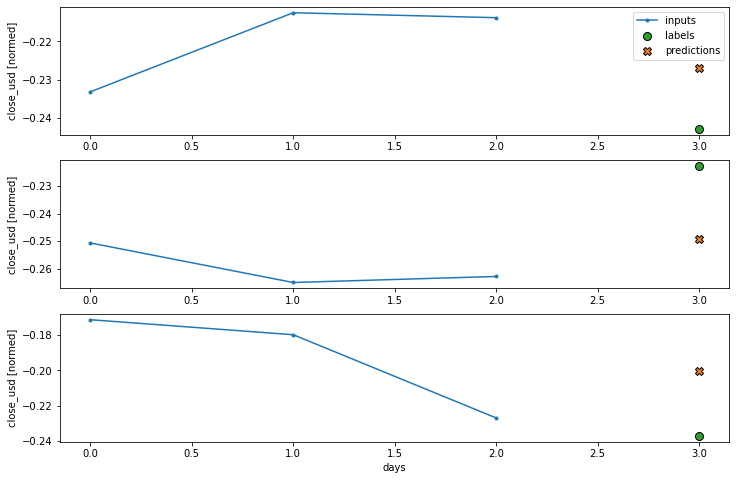

In [36]:
conv_window.plot(multi_step_dense, plot_col=my_col_name, plot_time=my_time_name)

Основным недостатком этого подхода является то, что полученная модель может быть выполнена только на входных окнах именно такой формы.

In [37]:
print('input shape:', wide_window.example[0].shape)
try:
    print('output shape:', multi_step_dense(wide_window.example[0]).shape)
except Exception as e:
    print(f'\n{type(e).__name__}:{e}')

input shape: (32, 24, 9)

InvalidArgumentError:Matrix size-incompatible: In[0]: [32,216], In[1]: [27,32] [Op:MatMul]


## Свёрточная нейронная сеть

![](images/model-convolution.png)

In [38]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(my_conv_width,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [39]:
print('input shape:', conv_window.example[0].shape)
print('output shape:', conv_model(conv_window.example[0]).shape)

input shape: (32, 3, 9)
output shape: (32, 1, 1)


In [40]:
%%time
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['conv'] = conv_model.evaluate(conv_window.val)
test_performance['conv'] = conv_model.evaluate(conv_window.test)

4/4 [==============================] - 0s 2ms/step - loss: 0.0013 - mean_absolute_error: 0.0287
Wall time: 4.2 s


In [41]:
print("wide window:")
print('input shape:', wide_window.example[0].shape)
print('labels shape:', wide_window.example[1].shape)
print('output shape:', conv_model(wide_window.example[0]).shape)

wide window:
input shape: (32, 24, 9)
labels shape: (32, 24, 1)
output shape: (32, 22, 1)


In [42]:
wide_conv_window = WindowGenerator(
    input_width=wide_input_width,
    label_width=wide_label_width,
    shift=my_shift,
    label_columns=[my_col_name],
    train_df=train_df, val_df=val_df, test_df=test_df)
wide_conv_window

total window size: 27
input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
label column name(s): ['close_usd']

In [43]:
print("wide conv window:")
print('input shape:', wide_conv_window.example[0].shape)
print('labels shape:', wide_conv_window.example[1].shape)
print('output shape:', conv_model(wide_conv_window.example[0]).shape)

wide conv window:
input shape: (32, 26, 9)
labels shape: (32, 24, 1)
output shape: (32, 24, 1)


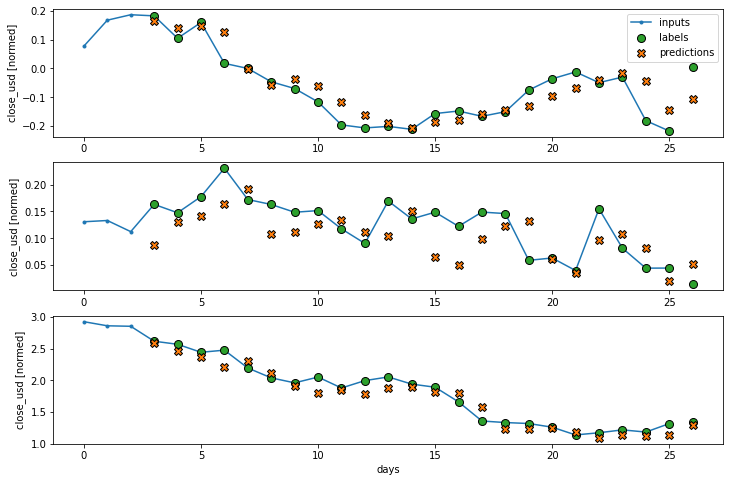

In [44]:
wide_conv_window.plot(conv_model, plot_col=my_col_name, plot_time=my_time_name)

## Рекуррентная нейронная сеть

Рекуррентная нейронная сеть (RNN) – это тип нейронной сети, хорошо подходящий для данных временных рядов. RNN обрабатывают временной ряд шаг за шагом, поддерживая внутреннее состояние от шага к шагу.

Важным аргументом конструктора для всех слоёв Keras RNN является аргумент ```return_sequences```. Этот параметр позволяет настроить слой одним из двух способов.

Если значение по умолчанию равно ```False```, слой возвращает только выходные данные конечного временного шага, давая модели время для прогрева её внутреннего состояния перед выполнением одного прогноза:
![](images/model-recurrent-1.png)

Если ```True```, слой возвращает выходные данные для каждого входа. Это полезно для:
– использования нескольких рекуррентных слоёв;
– обучение модели на нескольких временных шагах одновременно.
![](images/model-recurrent-2.png)

In [45]:
lstm_model = tf.keras.models.Sequential([
    # shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [46]:
print('input shape:', wide_window.example[0].shape)
print('output shape:', lstm_model(wide_window.example[0]).shape)

input shape: (32, 24, 9)
output shape: (32, 24, 1)


In [47]:
%%time
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['lstm'] = lstm_model.evaluate(wide_window.val)
test_performance['lstm'] = lstm_model.evaluate(wide_window.test)

3/3 [==============================] - 0s 0s/step - loss: 0.0028 - mean_absolute_error: 0.0332
Wall time: 18.6 s


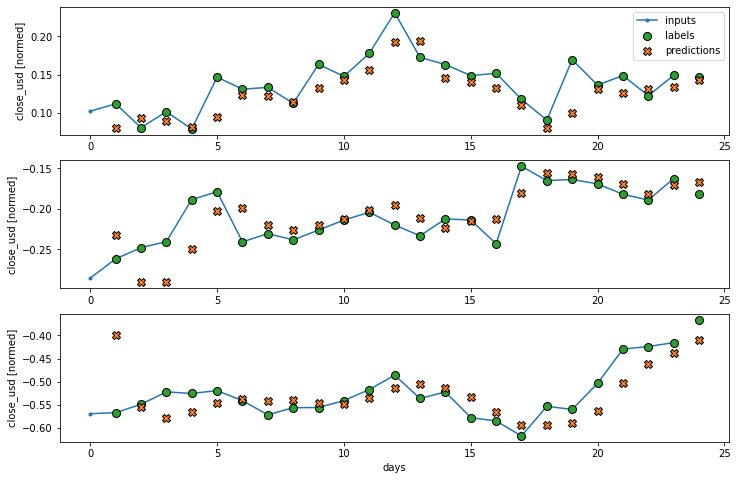

In [48]:
wide_window.plot(lstm_model, plot_col=my_col_name, plot_time=my_time_name)

## Сравнение моделей

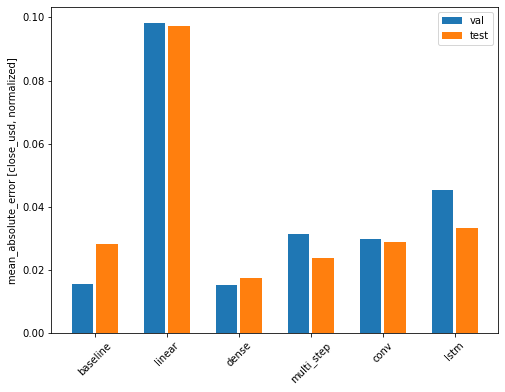

In [49]:
x = np.arange(len(test_performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')

val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in test_performance.values()]

plt.ylabel(f'mean_absolute_error [{my_col_name}, normalized]')
plt.bar(x - 0.17, val_mae, width, label='val')
plt.bar(x + 0.17, test_mae, width, label='test')
plt.xticks(ticks=x, labels=test_performance.keys(), rotation=45)
_ = plt.legend()

In [50]:
for name, value in test_performance.items():
    print(f'{name:12s}: {value[1]:0.4f}')

baseline    : 0.0281
linear      : 0.0971
dense       : 0.0174
multi_step  : 0.0238
conv        : 0.0287
lstm        : 0.0332


## Модели с несколькими выходами (multi-output models)

Все модели до сих пор предсказывали одну выходной признак для одного временного шага.

Все рассмотренные ранее модели могут быть преобразованы для прогнозирования нескольких признаков, просто изменив количество единиц измерения в выходном слое и настроив обучающие окна для включения всех признаков в метки.

In [51]:
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels
    # if you don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1,
    train_df=train_df, val_df=val_df, test_df=test_df)

wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    train_df=train_df, val_df=val_df, test_df=test_df)

for example_inputs, example_labels in wide_window.train.take(1):
    print(f'inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'labels shape (batch, time, features): {example_labels.shape}')

inputs shape (batch, time, features): (32, 24, 9)
labels shape (batch, time, features): (32, 24, 9)


In [52]:
baseline = Baseline()
baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance2['baseline'] = baseline.evaluate(wide_window.val)
test_performance2['baseline'] = baseline.evaluate(wide_window.test)

3/3 [==============================] - 0s 2ms/step - loss: 0.0100 - mean_absolute_error: 0.0466


In [53]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(dense, single_step_window)

IPython.display.clear_output()
val_performance2['dense'] = dense.evaluate(single_step_window.val)
test_performance2['dense'] = dense.evaluate(single_step_window.test)

4/4 [==============================] - 0s 2ms/step - loss: 0.0126 - mean_absolute_error: 0.0552


In [54]:
%%time
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    train_df=train_df, val_df=val_df, test_df=test_df)

lstm_model = tf.keras.models.Sequential([
    # shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance2['lstm'] = lstm_model.evaluate( wide_window.val)
test_performance2['lstm'] = lstm_model.evaluate( wide_window.test)

3/3 [==============================] - 0s 5ms/step - loss: 0.0142 - mean_absolute_error: 0.0714
Wall time: 17.6 s


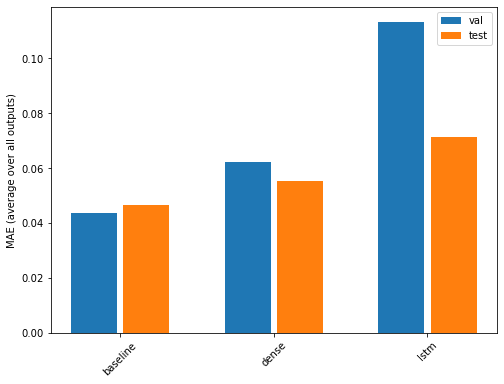

In [55]:
x = np.arange(len(test_performance2))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')

val_mae = [v[metric_index] for v in val_performance2.values()]
test_mae = [v[metric_index] for v in test_performance2.values()]

plt.bar(x - 0.17, val_mae, width, label='val')
plt.bar(x + 0.17, test_mae, width, label='test')
plt.xticks(ticks=x, labels=test_performance2.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

In [56]:
for name, value in test_performance2.items():
    print(f'{name:15s}: {value[1]:0.4f}')

baseline       : 0.0466
dense          : 0.0552
lstm           : 0.0714


## Многошаговые модели

Как модели с одним выходом, так и модели с несколькими выходами делали прогнозы на один шаг будущее.

При многошаговом прогнозировании модель должна научиться предсказывать диапазон будущих значений. Таким образом, в отличие от одношаговой модели, где предсказывается только одна будущая точка, многошаговая модель предсказывает последовательность будущих значений.

Существует два подхода многошагового предсказания:
– прогнозы с одним выстрелом, когда весь временной ряд предсказывается сразу;
– авторегрессионные прогнозы, когда модель предсказывает один шаг, а её выходные данные возвращаются в качестве входных данных.

total window size: 48
input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
label column name(s): None

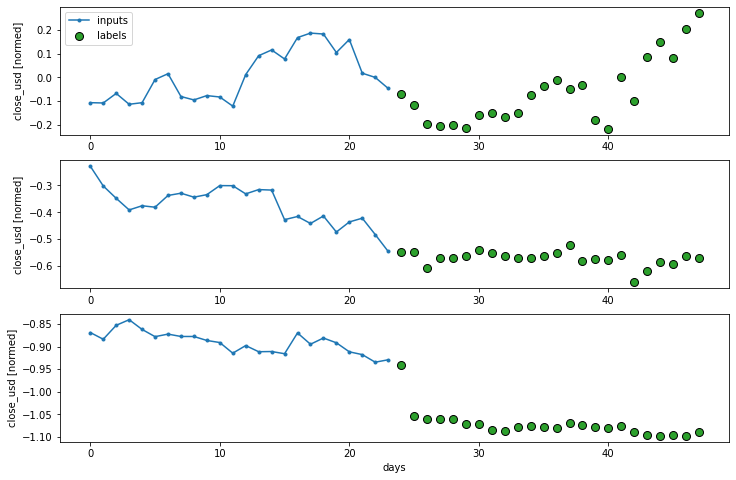

In [57]:
multi_window = WindowGenerator(input_width=24, label_width=my_out_steps, shift=my_out_steps,
                               train_df=train_df, val_df=val_df, test_df=test_df)
multi_window.plot(plot_col=my_col_name, plot_time=my_time_name)
multi_window

## Линия отсчёта (baseline)

Простая линия отсчёта для этой задачи состоит в том, чтобы повторить последний шаг времени ввода для требуемого количества временных шагов вывода.

![](images/model-multistep-baseline-1.png)

In [58]:
class MultistepLastBaseline(tf.keras.Model):
    def call(self, inputs):
        return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

In [75]:
last_baseline = MultistepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance['last'] = last_baseline.evaluate(multi_window.val)
multi_test_performance['last'] = last_baseline.evaluate(multi_window.test)

2/2 [==============================] - 0s 4ms/step - loss: 0.0256 - mean_absolute_error: 0.1129


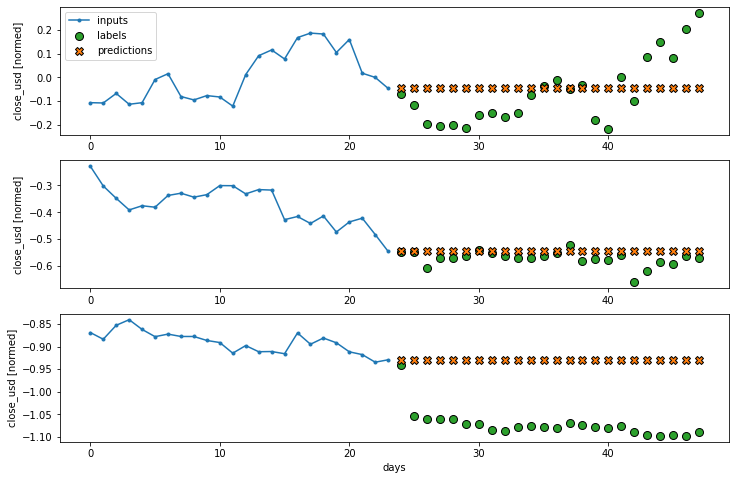

In [60]:
multi_window.plot(last_baseline, plot_col=my_col_name, plot_time=my_time_name)

Поскольку эта задача состоит в том, чтобы предсказать n шагов, учитывая n последних шагов, другой простой подход состоит в том, чтобы повторить предыдушие n, предполагая, что следующие будут такими же.

![](images/model-multistep-baseline-2.png)

In [61]:
class RepeatBaseline(tf.keras.Model):
    def call(self, inputs):
        return inputs

In [62]:
repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance['repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_test_performance['repeat'] = repeat_baseline.evaluate(multi_window.test)

2/2 [==============================] - 0s 0s/step - loss: 0.0447 - mean_absolute_error: 0.1767


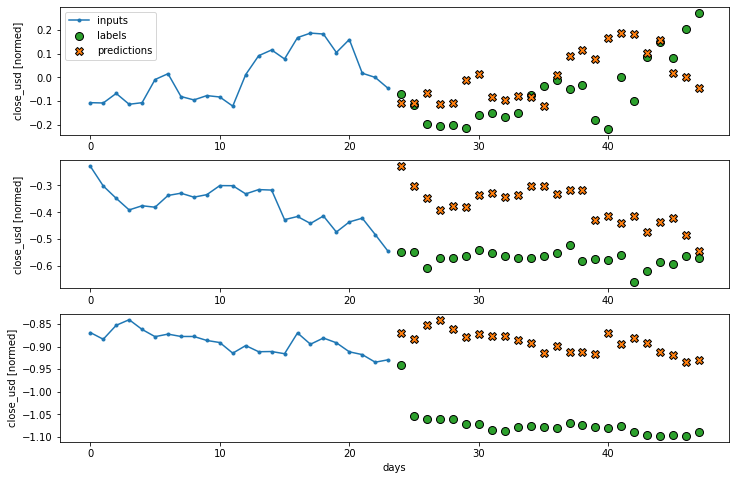

In [63]:
multi_window.plot(repeat_baseline, plot_col=my_col_name, plot_time=my_time_name)

## Предсказание всей последовательности за один шаг

## Линейная модель

Простая линейная модель, основанная на последнем временном шаге ввода, работает лучше, чем линия отсчёта (baseline). Модель должна предсказывать n временных шагов с одного входного временного шага с линейной проекцией. Он может захватить только низкоразмерный срез поведения, вероятно, основанный в основном на времени суток и времени года.

![](images/model-multistep-linear.png)

In [64]:
multi_linear_model = tf.keras.Sequential([
    # shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

In [65]:
%%time
history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['linear'] = multi_linear_model.evaluate(multi_window.val)
multi_test_performance['linear'] = multi_linear_model.evaluate(multi_window.test)

2/2 [==============================] - 0s 8ms/step - loss: 0.0460 - mean_absolute_error: 0.1339
Wall time: 7.02 s


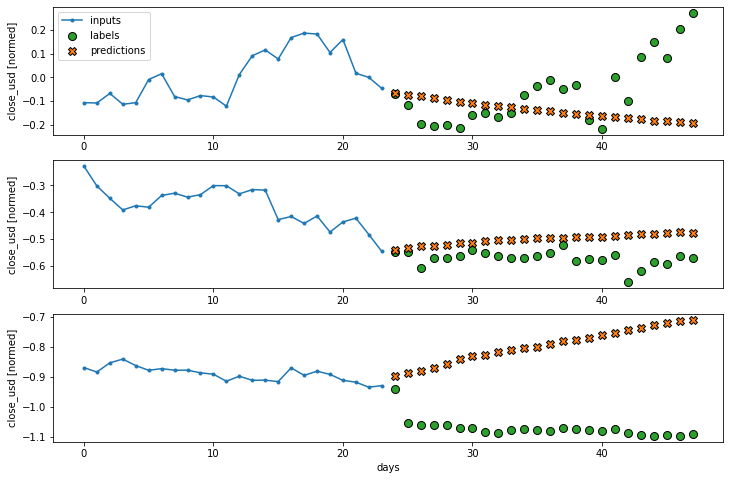

In [66]:
multi_window.plot(multi_linear_model, plot_col=my_col_name, plot_time=my_time_name)

## Полносвязанная модель (dense)

Добавление плотного слоя между входом и выходом даёт линейной модели больше мощности, но модель по-прежнему основана только на одном временном шаге ввода.

In [67]:
multi_dense_model = tf.keras.Sequential([
    # shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

In [68]:
%%time
history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['dense'] = multi_dense_model.evaluate(multi_window.val)
multi_test_performance['dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)

5/5 [==============================] - 0s 3ms/step - loss: 0.0484 - mean_absolute_error: 0.1066
Wall time: 3.77 s


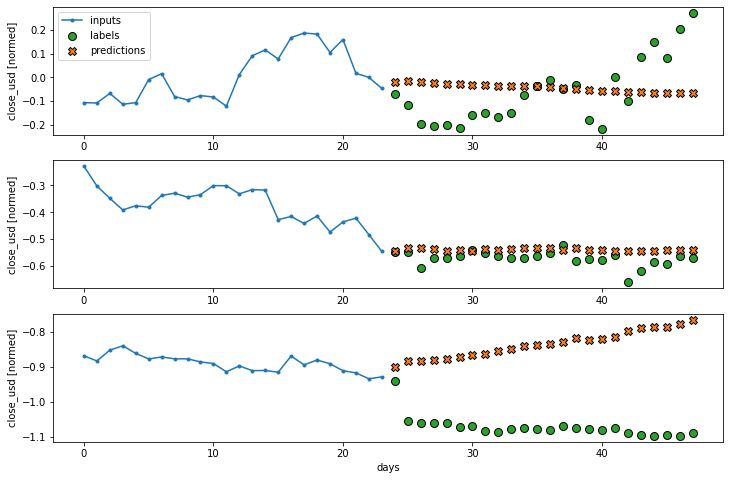

In [69]:
multi_window.plot(multi_dense_model, plot_col=my_col_name, plot_time=my_time_name)

## Cвёрточная нейрнонная сеть

Свёрточная модель делает прогнозы на основе истории фиксированной ширины, что может привести к лучшей производительности, чем плотная модель, поскольку она может видеть, как всё меняется с течением времени.

![](images/model-multistep-convolution.png)

In [70]:
multi_conv_model = tf.keras.Sequential([
    # shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

In [71]:
%%time
history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['conv'] = multi_conv_model.evaluate(multi_window.val)
multi_test_performance['conv'] = multi_conv_model.evaluate(multi_window.test)

2/2 [==============================] - 0s 0s/step - loss: 0.0373 - mean_absolute_error: 0.1459
Wall time: 2.64 s


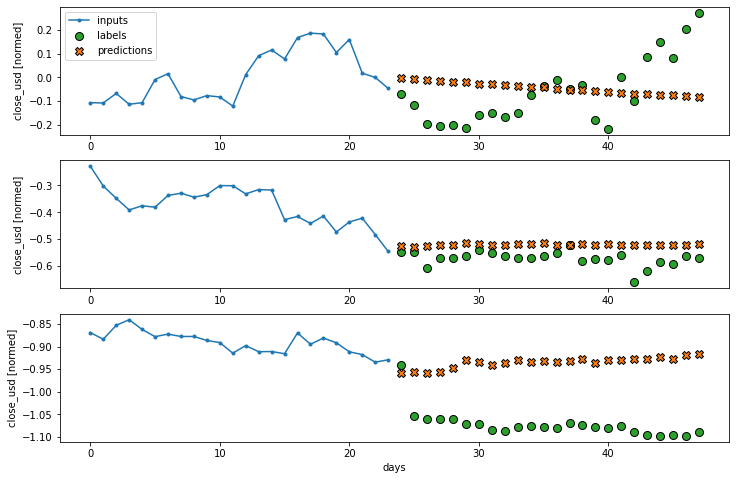

In [72]:
multi_window.plot(multi_conv_model, plot_col=my_col_name, plot_time=my_time_name)